In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote_auto_distribution_kept.csv')
print("df_under is the oversample data frame\n", data.rate.value_counts().sort_index())

df_under is the oversample data frame
 1     38
2    174
3    692
4    762
5    350
Name: rate, dtype: int64


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class Knn (KNNBasic):
    def __init__(self, sim_options={}, bsl_options={}):
        KNNBasic.__init__(self, k = 5, sim_options=sim_options, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)

    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNBasic.fit(self, trainset_fold)
            train_prediction = KNNBasic.test(self, trainset_fold.build_testset())
            prediction = KNNBasic.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNBasic.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## Knn SGD

* knn cosine, user based

In [4]:
knn = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn.create_reader(data)
predictions = knn.fit()
#acc
metrics = knn.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2197
RMSE: 0.5644
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2355
RMSE: 0.5221
Computing the cosine similarity matrix...


Done computing similarity matrix.
RMSE: 0.2314
RMSE: 0.5338
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2185
RMSE: 0.5563
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2365
RMSE: 0.5532
###############################################
The Results are: 

Average RMSE on Training Set: 0.22830024631264748
Average RMSE on Test Set: 0.5459611732712056
RMSE: 0.5166
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5165724093530261
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.5166
MAE:  0.2588
MSE: 0.2668
Precision: 0.67
Recall: 0.64
the acc is 79.21


/tmp/ipykernel_3792/161991997.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [5]:
knn2 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn2.create_reader(data)
predictions = knn2.fit()
#acc
metrics = knn2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.


RMSE: 0.7232
RMSE: 0.8490
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7284
RMSE: 0.8265
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7277
RMSE: 0.7904
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7306
RMSE: 0.7866
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7246
RMSE: 0.8112
###############################################
The Results are: 

Average RMSE on Training Set: 0.726918496428273
Average RMSE on Test Set: 0.8127442847830627
RMSE: 0.7990
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7989869953493408
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7990
MAE:  0.5887
MSE: 0.6384
Precision: 0.59
Recall: 0.59
the acc is 52.72


/tmp/ipykernel_3792/3130600781.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3130600781.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [6]:
knn3 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn3.create_reader(data)
predictions = knn3.fit()
#acc
metrics = knn3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1443
RMSE: 0.5907
Computing the msd similarity matrix...
Done computing similarity matrix.


RMSE: 0.1217
RMSE: 0.4715
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1304
RMSE: 0.5953
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1443
RMSE: 0.5232
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1464
RMSE: 0.5989
###############################################
The Results are: 

Average RMSE on Training Set: 0.13740154740478902
Average RMSE on Test Set: 0.5559363612596242
RMSE: 0.4815
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.48151106299413
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.4815
MAE:  0.2388
MSE: 0.2319
Precision: 0.65
Recall: 0.66
the acc is 80.45


/tmp/ipykernel_3792/3369594395.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3369594395.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared diference, item based

In [7]:
knn4 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn4.create_reader(data)
predictions = knn4.fit()
#acc
metrics = knn4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1552
RMSE: 0.5663
Computing the msd similarity matrix...
Done computing similarity matrix.


RMSE: 0.1209
RMSE: 0.5831
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1606
RMSE: 0.4728
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1545
RMSE: 0.5399
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1566
RMSE: 0.5396
###############################################
The Results are: 

Average RMSE on Training Set: 0.14956388403488857
Average RMSE on Test Set: 0.5403327212781746
RMSE: 0.5633
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5632637953618914
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.5633
MAE:  0.2815
MSE: 0.3173
Precision: 0.67
Recall: 0.67
the acc is 77.72


/tmp/ipykernel_3792/1900242280.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/1900242280.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, user based

In [8]:
knn5 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn5.create_reader(data)
predictions = knn5.fit()
#acc
metrics = knn5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1397
RMSE: 0.5641
Computing the pearson similarity matrix...


Done computing similarity matrix.
RMSE: 0.0972
RMSE: 0.5915
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1404
RMSE: 0.5324
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1443
RMSE: 0.4864
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1347
RMSE: 0.5169
###############################################
The Results are: 

Average RMSE on Training Set: 0.1312567514884732
Average RMSE on Test Set: 0.5382720732022137
RMSE: 0.5266
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5266158909677572
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.5266
MAE:  0.2408
MSE: 0.2773
Precision: 0.68
Recall: 0.67
the acc is 81.68


/tmp/ipykernel_3792/3339916766.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3339916766.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, item based

In [9]:
knn6 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn6.create_reader(data)
predictions = knn6.fit()
#acc
metrics = knn6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.


RMSE: 0.0869
RMSE: 0.5765
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0830
RMSE: 0.5207
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0941
RMSE: 0.6119
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1062
RMSE: 0.5381
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0984
RMSE: 0.5218
###############################################
The Results are: 

Average RMSE on Training Set: 0.0937283648051172
Average RMSE on Test Set: 0.5538098705784329
RMSE: 0.5289
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5288580087095731
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.5289
MAE:  0.2559
MSE: 0.2797
Precision: 0.66
Recall: 0.67
the acc is 79.21


/tmp/ipykernel_3792/3614094042.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3614094042.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [10]:
knn7 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn7.create_reader(data)
predictions = knn7.fit()
#acc
metrics = knn7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


RMSE: 0.1207
RMSE: 0.5335
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0973
RMSE: 0.5772
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1229
RMSE: 0.5390
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0922
RMSE: 0.5989
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1347
RMSE: 0.4612
###############################################
The Results are: 

Average RMSE on Training Set: 0.11355114280633401
Average RMSE on Test Set: 0.5419579316390546
RMSE: 0.5620
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5620353687532186
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5620
MAE:  0.2858
MSE: 0.3159
Precision: 0.66
Recall: 0.68
the acc is 7

/tmp/ipykernel_3792/3960392171.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3960392171.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [11]:
knn8 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn8.create_reader(data)
predictions = knn8.fit()
#acc
metrics = knn8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


RMSE: 0.1673
RMSE: 0.5420
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1642
RMSE: 0.4956
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1444
RMSE: 0.5703
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1673
RMSE: 0.4902
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1944
RMSE: 0.5956
###############################################
The Results are: 

Average RMSE on Training Set: 0.1675050955841324
Average RMSE on Test Set: 0.538737306015001
RMSE: 0.5643
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5643297990118068
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5643
MAE:  0.2898
MSE: 0.3185
Precision: 0.68
Recall: 0.67
the acc is 77.

/tmp/ipykernel_3792/3933834523.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3933834523.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## Knn Alternating Least Squares (ALS)

* knn cosine, user based

In [12]:
knn9 = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn9.create_reader(data)
predictions = knn9.fit()
#acc
metrics = knn9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2265
RMSE: 0.5859
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2017
RMSE: 0.5379
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2298
RMSE: 0.5450
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2350
RMSE: 0.5551
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2248
RMSE: 0.4978
###############################################
The Results are: 

Average RMSE on Training Set: 0.22356801449085784
Average RMSE on Test Set: 0.5443437816348747
RMSE: 0.5448
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5448356635819183
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.5448
MAE:  0.2816
MSE: 0.2968
Precision: 0.72
Recall: 0.71
the acc is 79.21


/tmp/ipykernel_3792/3513140556.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3513140556.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [13]:
knn10 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn10.create_reader(data)
predictions = knn10.fit()
#acc
metrics = knn10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.


RMSE: 0.6930
RMSE: 0.8129
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7282
RMSE: 0.8007
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7121
RMSE: 0.8337
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7061
RMSE: 0.8062
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7252
RMSE: 0.7934
###############################################
The Results are: 

Average RMSE on Training Set: 0.7129203730076838
Average RMSE on Test Set: 0.8093719105521314
RMSE: 0.8590
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.858976848153831
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8590
MAE:  0.6418
MSE: 0.7378
Precision: 0.62
Recall: 0.61
the acc is 47.03


/tmp/ipykernel_3792/857205367.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/857205367.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [14]:
knn11 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn11.create_reader(data)
predictions = knn11.fit()
#acc
metrics = knn11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1497
RMSE: 0.5290
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1266
RMSE: 0.5705
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1276
RMSE: 0.5736
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1578
RMSE: 0.5477
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1462
RMSE: 0.5459
###############################################
The Results are: 

Average RMSE on Training Set: 0.1415954564757178
Average RMSE on Test Set: 0.5533250692293287
RMSE: 0.5401
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.540136795090326
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.5401
MAE:  0.2735
MSE: 0.2917
Precision: 0.66
Recall: 0.64
the acc is 78.22


/tmp/ipykernel_3792/1804258722.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/1804258722.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, item based

In [15]:
knn12 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn12.create_reader(data)
predictions = knn12.fit()
#acc
metrics = knn12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1586
RMSE: 0.6050
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1309
RMSE: 0.5228
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1692
RMSE: 0.6113
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1575
RMSE: 0.5992
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1489
RMSE: 0.6031
###############################################
The Results are: 

Average RMSE on Training Set: 0.15301947269249028
Average RMSE on Test Set: 0.5883002426028043
RMSE: 0.4711
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.4710658265142192
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.4711
MAE:  0.2193
MSE: 0.2219
Precision: 0.75
Recall: 0.73
the acc is 84.65


/tmp/ipykernel_3792/262444695.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/262444695.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, user based

In [16]:
knn13 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn13.create_reader(data)
predictions = knn13.fit()
#acc
metrics = knn13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...


Done computing similarity matrix.
RMSE: 0.0954
RMSE: 0.5227
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1058
RMSE: 0.4879
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1157
RMSE: 0.5171
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1061
RMSE: 0.5292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1122
RMSE: 0.5693
###############################################
The Results are: 

Average RMSE on Training Set: 0.10705492750267795
Average RMSE on Test Set: 0.5252353328800786
RMSE: 0.5920
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5920380934506426
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.5920
MAE:  0.2880
MSE: 0.3505
Precision: 0.61
Recall: 0.61
the acc is 78.47


/tmp/ipykernel_3792/1092855449.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/1092855449.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, item based

In [17]:
knn14 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn14.create_reader(data)
predictions = knn14.fit()
#acc
metrics = knn14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1159
RMSE: 0.5469
Computing the pearson similarity matrix...
Done computing similarity matrix.


RMSE: 0.1051
RMSE: 0.5862
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1156
RMSE: 0.5611
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1243
RMSE: 0.5454
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1393
RMSE: 0.5208
###############################################
The Results are: 

Average RMSE on Training Set: 0.12002333063882116
Average RMSE on Test Set: 0.5520925692644404
RMSE: 0.5346
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5346350799207337
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.5346
MAE:  0.2750
MSE: 0.2858
Precision: 0.61
Recall: 0.60
the acc is 77.23


/tmp/ipykernel_3792/3580080987.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3580080987.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [18]:
knn15 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn15.create_reader(data)
predictions = knn15.fit()
#acc
metrics = knn15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1127
RMSE: 0.5933
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1226
RMSE: 0.4897
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


RMSE: 0.1165
RMSE: 0.5549
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1223
RMSE: 0.5266
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0867
RMSE: 0.5862
###############################################
The Results are: 

Average RMSE on Training Set: 0.11214509119114721
Average RMSE on Test Set: 0.5501180484023269
RMSE: 0.5171
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5171419638840019
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5171
MAE:  0.2625
MSE: 0.2674
Precision: 0.69
Recall: 0.69
the acc is 78.71


/tmp/ipykernel_3792/3271800746.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3271800746.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [19]:
knn16 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn16.create_reader(data)
predictions = knn16.fit()
#acc
metrics = knn16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1565
RMSE: 0.5390
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1552
RMSE: 0.5087
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1551
RMSE: 0.5974
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


RMSE: 0.1576
RMSE: 0.5255
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1370
RMSE: 0.5195
###############################################
The Results are: 

Average RMSE on Training Set: 0.15228100601550015
Average RMSE on Test Set: 0.5380061563057283
RMSE: 0.5928
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5928424833799403
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5928
MAE:  0.3035
MSE: 0.3515
Precision: 0.65
Recall: 0.64
the acc is 77.72


/tmp/ipykernel_3792/3154310150.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_3792/3154310150.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
11,12,KnnBasic,MSD,ALS,False,0.471066,0.219315,0.221903,0.745397,0.730073,84.653465
2,3,KnnBasic,MSD,SGD,True,0.481511,0.238830,0.231853,0.652574,0.660445,80.445545
0,1,KnnBasic,Cosine,SGD,True,0.516572,0.258762,0.266847,0.667574,0.637662,79.207921
14,15,KnnBasic,(shrunk) pearson corr coeff,ALS,True,0.517142,0.262543,0.267436,0.694809,0.691047,78.712871
4,5,KnnBasic,pearson corr coeff,SGD,True,0.526616,0.240760,0.277324,0.678535,0.673708,81.683168
5,6,KnnBasic,pearson corr coeff,SGD,False,0.528858,0.255916,0.279691,0.664321,0.672328,79.207921
13,14,KnnBasic,pearson corr coeff,ALS,False,0.534635,0.275003,0.285835,0.612260,0.604638,77.227723
10,11,KnnBasic,MSD,ALS,True,0.540137,0.273469,0.291748,0.664951,0.636386,78.217822
8,9,KnnBasic,Cosine,ALS,True,0.544836,0.281596,0.296846,0.720988,0.707677,79.207921
6,7,KnnBasic,(shrunk) pearson corr coeff,SGD,True,0.562035,0.285818,0.315884,0.655021,0.679167,77.970297


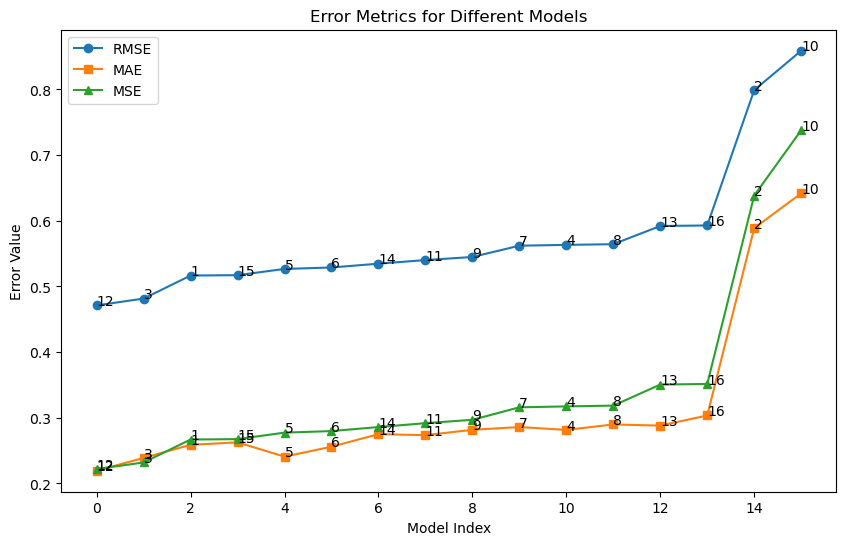

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

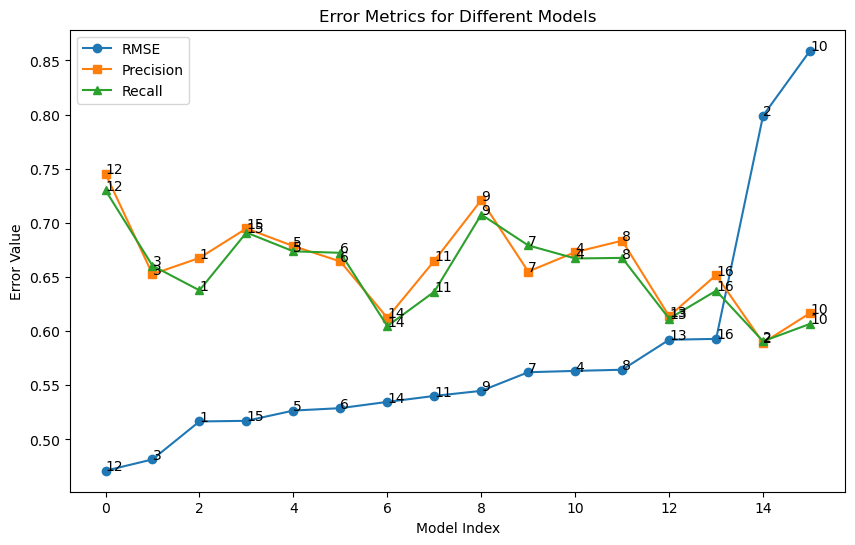

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

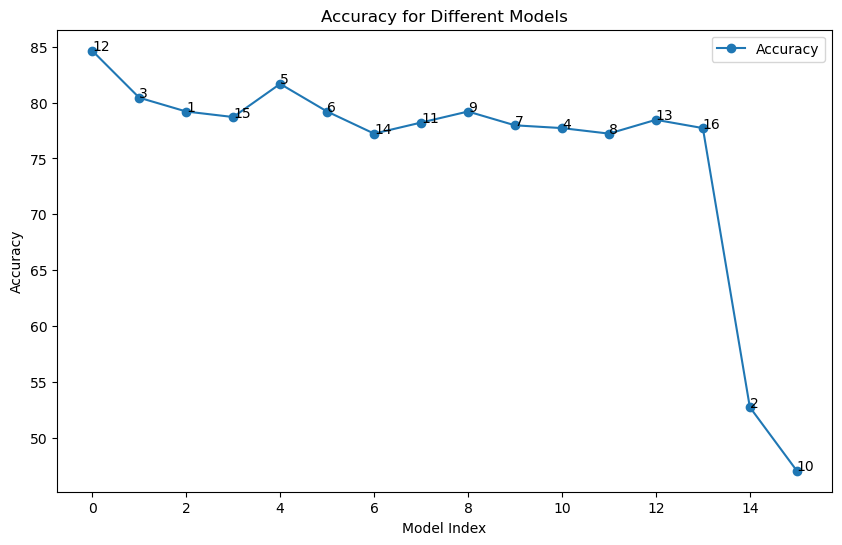

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
knn.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 15 with sim 0.000000000000000
user 5 with sim 0.000000000000000
user 5 with sim 0.000000000000000
user 15 with sim 0.000000000000000
user 6 with sim 0.000000000000000
And the baseline estimate is: 2.809947426304387

#####

Note: If the baseline is 3.5984496124031007 then the value is a default value, Otherwise not


In [25]:
df_pred = knn.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,"""PG Rosa"" Pinot grigio",2.0,1.930081,"{'actual_k': 5, 'was_impossible': False}",46,7,0.069919
1,00324bc3-0b35-4051-bc6d-9c258a4252c2,Cavalcaonte Barbera Forlí,5.0,5.000000,"{'actual_k': 5, 'was_impossible': False}",39,39,0.000000
2,5ccd8030-047b-432c-a630-d784ab415756,Bel Colle,3.0,3.000000,"{'actual_k': 5, 'was_impossible': False}",158,31,0.000000
3,5ccd8030-047b-432c-a630-d784ab415756,Bel Colle,3.0,3.000000,"{'actual_k': 5, 'was_impossible': False}",158,31,0.000000
4,b61f83a4-48c5-49a5-aee5-72f7d5221b2a,Sauvignon Blanc,4.0,3.586047,"{'was_impossible': True, 'reason': 'Not enough...",7,8,0.413953
5,df904a46-c461-4233-9d44-6ac11a8bbddc,Angiolo Puccini Organic Rosso Toscana,4.0,4.000000,"{'actual_k': 5, 'was_impossible': False}",14,2,0.000000
6,c2dfb861-cdad-4fb2-9460-fc794c7f6cad,Merlot,4.0,3.586047,"{'was_impossible': True, 'reason': 'User and/o...",2,1,0.413953
7,9a3cc655-c88e-4c1b-95e2-add7579ff4c2,Brachetto Piemonte,3.0,3.000000,"{'actual_k': 5, 'was_impossible': False}",31,18,0.000000
8,2a62eecd-b0cd-4395-9f8c-7c912a208be2,19 crimes dark red,5.0,5.000000,"{'actual_k': 5, 'was_impossible': False}",85,31,0.000000
9,00324bc3-0b35-4051-bc6d-9c258a4252c2,Cavalcaonte Barbera Forlí,5.0,5.000000,"{'actual_k': 5, 'was_impossible': False}",39,39,0.000000


* best predictions

In [26]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
201,2a62eecd-b0cd-4395-9f8c-7c912a208be2,California chardonnay,4.0,4.0,"{'actual_k': 5, 'was_impossible': False}",85,14,0.0
232,3b1f7bc8-6a23-47e5-97df-043bd1b97f12,Bardolino,2.0,2.0,"{'actual_k': 4, 'was_impossible': False}",6,9,0.0
231,4eb7031c-da00-48f4-bc7f-0a1f1eda7cab,Bollicina,4.0,4.0,"{'actual_k': 5, 'was_impossible': False}",25,15,0.0
230,5ccd8030-047b-432c-a630-d784ab415756,Bel Colle,3.0,3.0,"{'actual_k': 5, 'was_impossible': False}",158,31,0.0
229,5ccd8030-047b-432c-a630-d784ab415756,Bel Colle,3.0,3.0,"{'actual_k': 5, 'was_impossible': False}",158,31,0.0
228,a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8,Big Easy Red,4.0,4.0,"{'actual_k': 5, 'was_impossible': False}",19,10,0.0
227,2b88ef27-7d56-4414-9c00-b23851f336d2,Brut Rosé,4.0,4.0,"{'actual_k': 5, 'was_impossible': False}",49,48,0.0
233,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Langhe Nebbiolo,3.0,3.0,"{'actual_k': 5, 'was_impossible': False}",224,84,0.0
223,5ccd8030-047b-432c-a630-d784ab415756,Bel Colle,3.0,3.0,"{'actual_k': 5, 'was_impossible': False}",158,31,0.0
221,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il Mattaglio Blanc de Blancs,5.0,5.0,"{'actual_k': 5, 'was_impossible': False}",224,22,0.0


* worst predictions

In [27]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
306,47edd867-4e96-411a-b436-970e5f750b03,Pinot Grigio,2.0,3.586047,"{'was_impossible': True, 'reason': 'User and/o...",1,5,1.586047
310,91cf68cc-9436-43e1-871d-33beef4d2337,E. Guigal Cotes du Rhone Blended,2.0,3.586047,"{'was_impossible': True, 'reason': 'User and/o...",33,0,1.586047
312,3d88fe74-6881-42bd-bb97-d67f2db649d7,Dark Horse Shiraz,2.0,3.586047,"{'was_impossible': True, 'reason': 'Not enough...",2,11,1.586047
349,3da6eec4-bd99-4370-be23-676baf750f19,Monterey Pinot Noir,2.0,3.586047,"{'was_impossible': True, 'reason': 'User and/o...",1,1,1.586047
112,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Fleurie Grand Pre,2.0,3.586047,"{'was_impossible': True, 'reason': 'User and/o...",58,1,1.586047
127,bc79b0e3-064d-4240-86de-e86499f577e8,Les Grands Blancs,2.0,3.586047,"{'was_impossible': True, 'reason': 'User and/o...",72,1,1.586047
263,c88644be-2c9b-42f0-9c4b-7f8e81795f43,Chardonnay,4.0,2.000000,"{'actual_k': 1, 'was_impossible': False}",3,17,2.000000
242,eadb1fb9-7260-4618-aa5a-8f2ebdca2077,Bread & Butter Pinor Noir 2020,1.0,3.586047,"{'was_impossible': True, 'reason': 'Not enough...",0,1,2.586047
256,91cf68cc-9436-43e1-871d-33beef4d2337,Vistamar Cabernet Sauvignon Reserva,1.0,3.586047,"{'was_impossible': True, 'reason': 'User and/o...",33,0,2.586047
281,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,le vigne di zamo refosco,1.0,3.586047,"{'was_impossible': True, 'reason': 'User and/o...",46,0,2.586047
